# تصنيف صور أرقام مكتوبة بخط اليد  

# تجهيز البرنامج  

In [1]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

 # جلب صور الارقام MNIST

In [2]:
from sklearn.datasets import fetch_openml
# This gives error because Scikit-Learn used to download MNIST from mldata.org, which was unfortunately pretty unstable
#mnist = fetch_openml('mnist_784', version=1)
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

•	مؤشر DESCR يصف مجموعة البيانات.  
•	مؤشر data يحتوي على مصفوفة بها صف واحد لكل مثيل instance وعمود واحد لكل خاصية feature.  
•	مؤشر target يحتوي على مصفوفة التسميات labels.


In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

ولكل صورة 784 ميزة features. هذا لأن كل صورة هي 28 × 28 بكسل، وكل ميزة تمثل كثافة بكسل واحد من 0 (أبيض) إلى 255 (أسود). 

In [5]:
28 * 28

784

Saving figure some_digit_plot


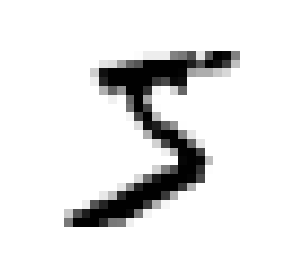

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

هذا يشبه الرقم 5 ، وهذا ما يخبرنا به الملصق بالفعل:

In [7]:
y[0]

'5'

تتوقع معظم خوارزميات تعلم الآلة أن تكون النتيجة رقمًا ، لذلك دعونا نحوّل النص الى رقم

In [8]:
y = y.astype(np.uint8)

تقسيم مجموعة بيانات MNIST إلى مجموعة تدريب (أول 60000 صورة) ومجموعة اختبار (آخر 10000 صورة)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# تدريب مصنف ثنائي Training a Binary Classifier

سيكون هذا مثال لمصنف ثنائي قادر على التمييز بين فئتين فقط الرقم هو 5 أو الرقم ليس 5. فلنقم بإنشاء متجهات النتيجة target vectors لـمهمة التصنيف هذه

In [10]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

الآن لنختار مصنفًا ونقوم بتدريبه. أفضل مكان للبدء هو مصنف التدرج العشوائي Stochastic Gradient Descent (SGD) ، باستخدام كلاس SGDClassifier من مكتبةـ Scikit-Learn

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

الآن يمكننا استخدامه للكشف عن صور الرقم 5:

In [12]:
sgd_clf.predict([some_digit])


array([ True])

# مقاييس الأداء Performance Measures

في بعض الأحيان ، ستحتاج إلى مزيد من التحكم في عملية التحقق المتقاطع أكثر مما يوفره Scikit-Learn بشكل جاهز. في هذه الحالة يمكنك تنفيذ التحقق المتقاطع بنفسك

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96355
0.93795
0.95615


دعنا نستخدم الدالة cross_val_score  لتقييم نموذج SGDClassifier باستخدام التحقق المتقاطع K-fold بثلاث طيات folds

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96355, 0.93795, 0.95615])

دعونا نلقي نظرة على المصنف البسيط الذي يصنف فقط كل صورة في فئة ليس الرقم 5

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

حساب مصفوفة الالتباس 

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53057,  1522],
       [ 1325,  4096]], dtype=int64)

أنت الآن جاهز للحصول على مصفوفة الالتباس باستخدام دالة confusion_matrix  فقط قم بتمرير الفئات المستهدفة (y_train_5)  والفئات المتوقعة (y_train_pred)

In [25]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)